# Objective
* 20181226: 
    * Predict stock price in next day using linear regression
    * Given prices for the last N days, we train a model, and predict for day N+1

In [197]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
Nmax = 14                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                               # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [198]:
def get_preds_lin_reg(df, target_col, N, pred_min):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
    Outputs
        pred_list  : the predictions for target_col
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(N, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['adj_close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                         # [[0]
                                         #  [1]
                                         #  [2]
                                         #  [3]
                                         #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(N)
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

# Load data

In [199]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12
5,2015-12-03,107.290001,107.480003,105.059998,105.449997,99.589470,3345600,12
6,2015-12-04,105.809998,107.540001,105.620003,107.389999,101.421646,4520000,12
7,2015-12-07,107.230003,107.269997,106.059998,106.550003,100.628342,3000500,12
8,2015-12-08,105.940002,106.400002,105.269997,105.910004,100.023895,3149600,12
9,2015-12-09,105.550003,106.750000,104.480003,105.000000,99.164467,4179800,12


# EDA

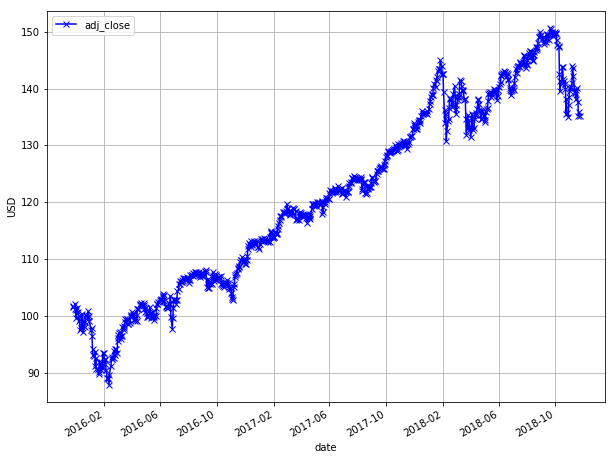

In [200]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Linear Regression

In [201]:
est_min = 0 # The min. predicted value possible 
RMSE = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(df, 'adj_close', N, 0)
    
    df['est' + '_N' + str(N)] = np.concatenate((np.zeros(N), est_list))
    RMSE.append(math.sqrt(mean_squared_error(est_list, df['adj_close'][N:])))
print('RMSE = ' + str(RMSE))
df.head()

RMSE = [0.9438709682356887, 1.3536549069239698, 1.2107159905537455, 1.1486050922686946, 1.1390254863119957, 1.161040478946979, 1.1932641176984793, 1.2207325697124596, 1.272664536869846, 1.329575000368121, 1.3843179717672185, 1.4313763124891288, 1.47297390511975, 1.5116666737113686]


,date,open,high,low,close,adj_close,volume,month,est_N1,est_N2,...,est_N5,est_N6,est_N7,est_N8,est_N9,est_N10,est_N11,est_N12,est_N13,est_N14
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11,101.497200,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11,101.648300,101.799400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12,101.213867,100.779434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12,102.167740,103.121613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


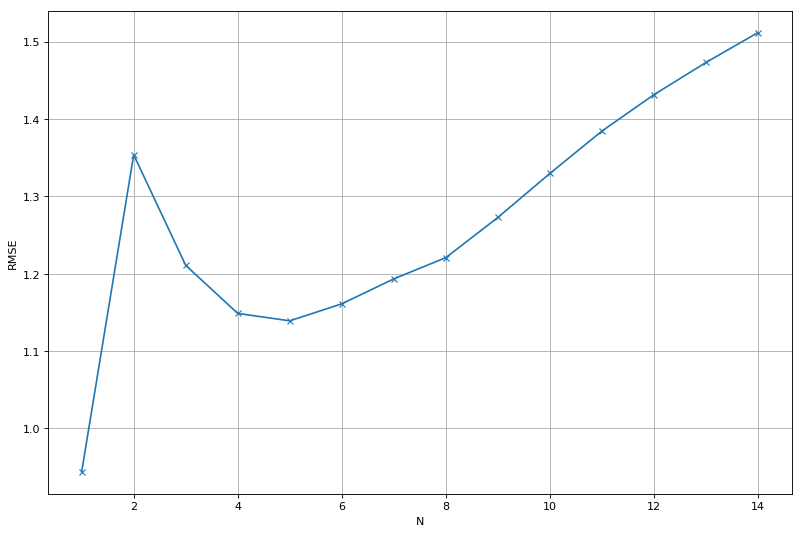

In [202]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

# Plot predictions for a specific day

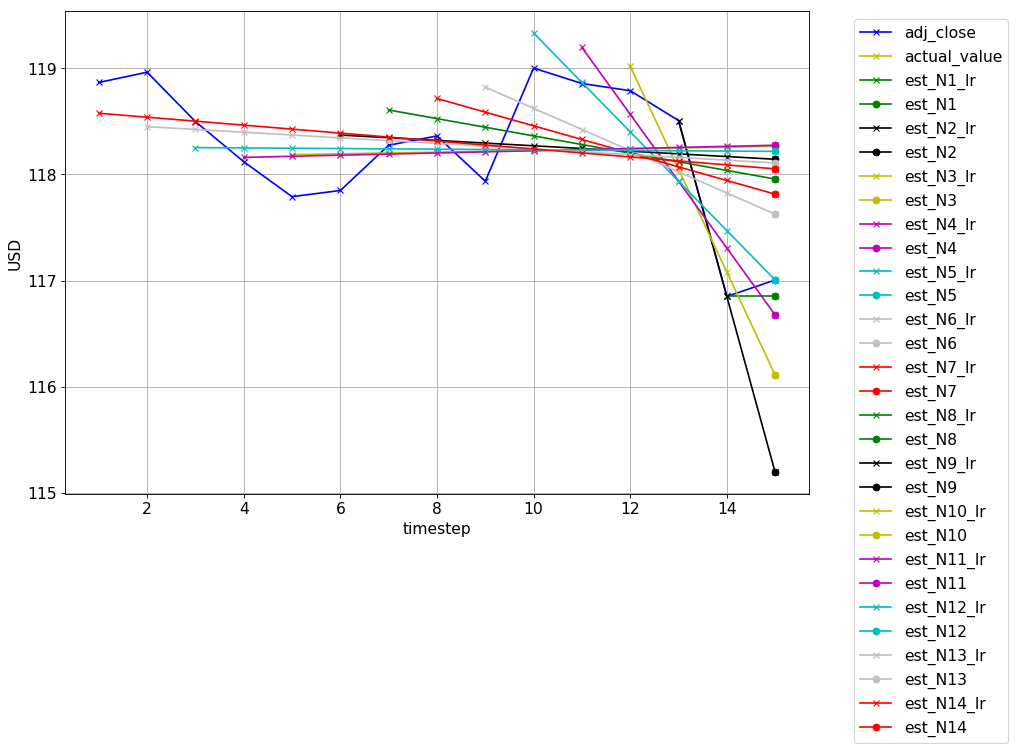

In [206]:
# Specify the day you are interested in
day = pd.Timestamp(date(2017, 3, 22))

df_temp = df[df['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax+2), df_temp[-Nmax-1:]['adj_close'], 'bx-')
plt.plot(Nmax+1, df_temp[-1:]['adj_close'], 'yx-')
legend_list = ['adj_close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(1, Nmax+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax+1-N,Nmax+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

# Plot predictions

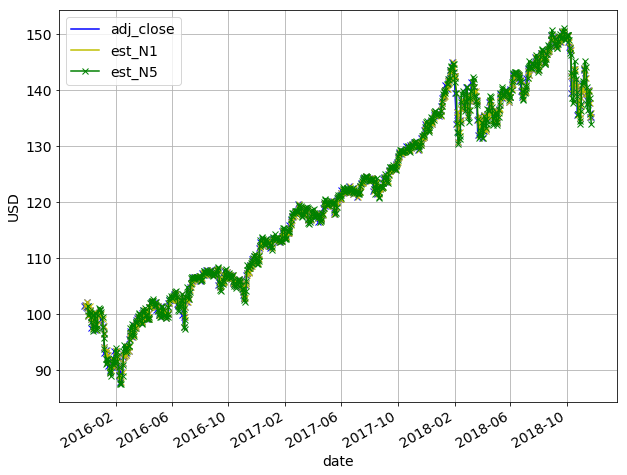

In [204]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = df[1:].plot(x='date', y='est_N1', style='yx-', grid=True, ax=ax)
ax = df[5:].plot(x='date', y='est_N5', style='gx-', grid=True, ax=ax)
ax.set_xlabel("date")
ax.set_ylabel("USD")

(736361.0, 736419.0)

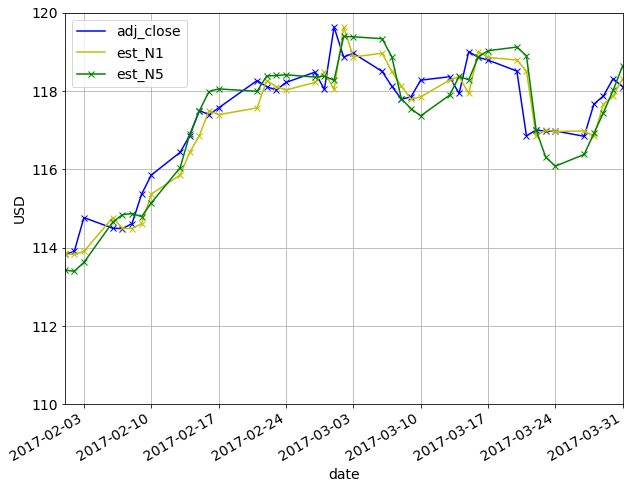

In [205]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = df[1:].plot(x='date', y='est_N1', style='yx-', grid=True, ax=ax)
ax = df[5:].plot(x='date', y='est_N5', style='gx-', grid=True, ax=ax)
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_ylim([110, 120])
ax.set_xlim([date(2017, 2, 1), date(2017, 3, 31)])

# Findings
* The lowest RMSE is 0.94 which is achieved using N=1, ie. using value on day t-1 to predict value on day t
* The next lowest RMSE is 1.14 which is achieved using N=5, ie. using values from days t-5 to t-1 to predict value on day t